In [1]:
runlist=[1380] # Select LED runs with bias set to 0x600, 0x680, 0x700 and 0x780
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy.signal import find_peaks
hep.style.use('ATLAS')  # or ATLAS/LHCb2

In [2]:
processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist, userunlist=True, remove=False, 
                                   treename='run', filter_name=["PEs"])
arr, arSpills = processor.getData(DATASET) # get akward array for "run" tree

In [3]:
arr_ = arr['PEs'].to_numpy().flatten()
#arr_ = arr['PEs'][:,0,0].to_numpy().flatten() # First SiPM from 1st FEB
arr_ = arr_[arr_>0]

In [4]:
# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

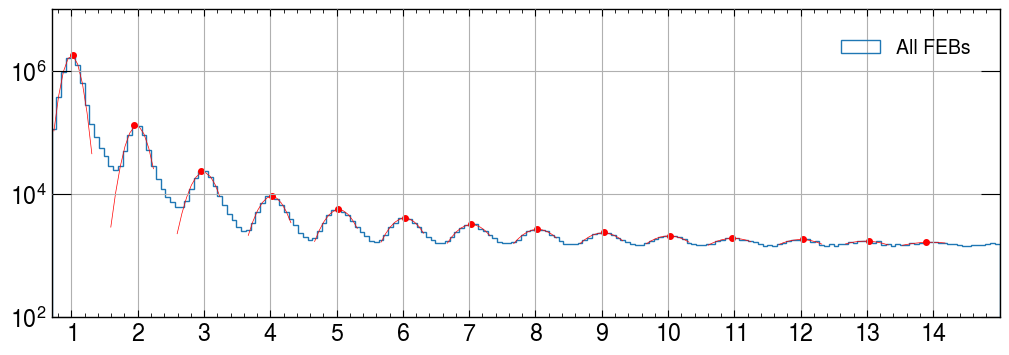

In [5]:
maxx=15
fig = plt.figure(figsize=[12,4])
ax = fig.gca()
ax.set_xticks(np.arange(0, maxx, 1))
hist, bins, _ = plt.hist(arr_, histtype='step', bins=200, range=(0.7, maxx), label="All FEBs"); #FEB0
bin_centers = (bins[:-1] + bins[1:]) / 2
peaks, _ = find_peaks(hist, width=3)

plt.yscale('log')
plt.grid()
plt.legend();

# Fit Gaussian to each peak
fit_peaks=[]
for peak in peaks:

    bin_center = bin_centers[peak]
    hist_peak = hist[peak]

    xmin = max(peak - 5, 0)
    xmax = peak+5    
    x=bin_centers[xmin:xmax]
    y=hist[xmin:xmax]
    
    p0 = [hist_peak, bin_center, 0.5]  # Initial guess for parameters
    popt, _ = curve_fit(gaussian, x, y, p0=p0)
    plt.plot(x, gaussian(x, *popt), color='red', linewidth=0.5, label='Gaussian Fit')
    fit_peaks.append(p0[1])

plt.plot(fit_peaks[0:maxx-1], hist[peaks], '.r');


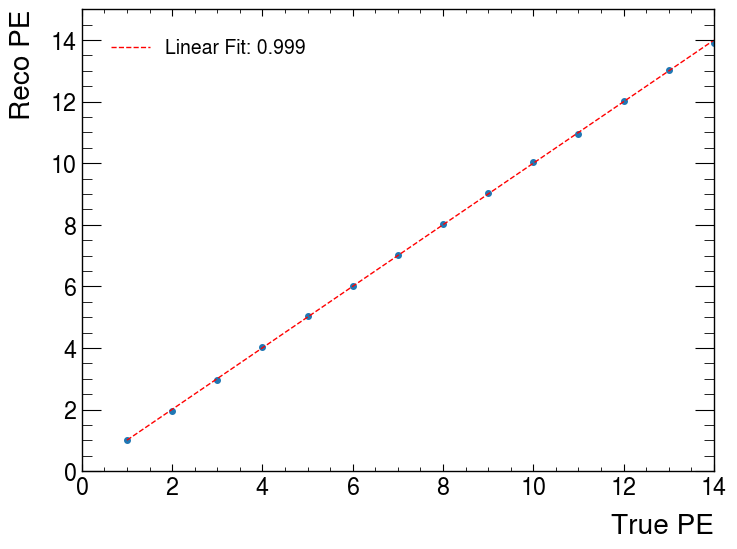

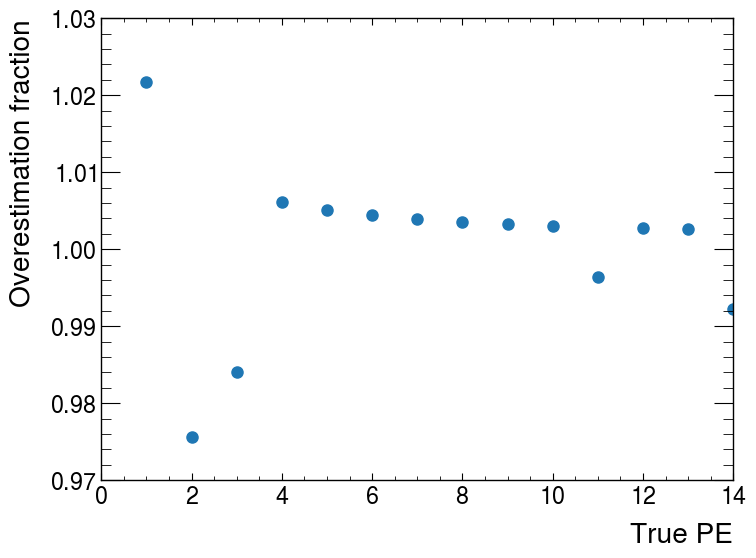

In [6]:
#y=bins[peaks]
y=np.array(fit_peaks)

x=range(1,len(y)+1)
plt.plot(x, y, '.');
m, b = np.polyfit(x, y, deg=1)

line = m * x + b
plt.plot(x, line, '--r', linewidth=1, label='Linear Fit: %0.3f'%m)
plt.xlabel("True PE")
plt.ylabel("Reco PE")
plt.legend();
plt.ylim(0,maxx)

plt.figure()
plt.plot(x, y/x, 'o');
plt.xlabel("True PE")
plt.ylabel("Overestimation fraction");
